In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import time
from math import sqrt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
!pip install shap
import shap
shap.initjs()
import joblib
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
dataframe = pd.read_excel('default_of_credit_card_clients.xls')
dataframe

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29999,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [4]:
dataframe.drop(0,inplace=True)
dataframe.drop(columns=["Unnamed: 0"],inplace=True)
dataframe

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29999,80000,1,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [5]:
dataframe.isnull().mean()*100

X1     0.0
X2     0.0
X3     0.0
X4     0.0
X5     0.0
X6     0.0
X7     0.0
X8     0.0
X9     0.0
X10    0.0
X11    0.0
X12    0.0
X13    0.0
X14    0.0
X15    0.0
X16    0.0
X17    0.0
X18    0.0
X19    0.0
X20    0.0
X21    0.0
X22    0.0
X23    0.0
Y      0.0
dtype: float64

In [25]:
dataframe["X4"].value_counts()

X4
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64

In [11]:
dataframe["X3"].unique()

array([2, 1, 3, 5, 4, 6, 0], dtype=object)

In [23]:
dataframe["X3"].value_counts()

X3
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64

In [12]:
dataframe["X6"].unique()

array([2, -1, 0, -2, 1, 3, 4, 8, 7, 5, 6], dtype=object)

In [30]:
dataframe["X6"].value_counts()

X6
0     14737
-1     5686
1      3688
-2     2759
2      2667
3       322
4        76
5        26
8        19
6        11
7         9
Name: count, dtype: int64

In [31]:
dataframe["X7"].value_counts()

X7
0     15730
-1     6050
2      3927
-2     3782
3       326
4        99
1        28
5        25
7        20
6        12
8         1
Name: count, dtype: int64

In [32]:
dataframe["X8"].value_counts()

X8
0     15764
-1     5938
-2     4085
2      3819
3       240
4        76
7        27
6        23
5        21
1         4
8         3
Name: count, dtype: int64

In [33]:
X, y = dataframe[dataframe.columns[~dataframe.columns.isin(["Y"])]], dataframe["Y"]

In [38]:
from scipy import stats

corr_dict = {}
for col in X:
    corr_dict[col] = stats.pointbiserialr(X[col], y)[0]
pd.Series(corr_dict).sort_values(ascending=False)

X6     0.324794
X7     0.263551
X8     0.235253
X9     0.216614
X10    0.204149
X11    0.186866
X3     0.028006
X5     0.013890
X17   -0.005372
X16   -0.006760
X15   -0.010156
X14   -0.014076
X13   -0.014193
X12   -0.019644
X4    -0.024339
X2    -0.039961
X23   -0.053183
X22   -0.055124
X20   -0.056250
X21   -0.056827
X19   -0.058579
X18   -0.072929
X1    -0.153520
dtype: float64

From this we can see the variables with the most impact on whether a client is given a credit card are X6-X11: (History of past payment, tracked monthly payment records from April to September 2005) and X1: Amount of the given credit (NT dollar)

In [63]:
features = ["X6","X7","X8","X9","X10","X11","X1"]
X = dataframe[features]
y = dataframe.Y

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
print ('Training observations: %d\nTest observations: %d' % (X_train.shape[0], X_test.shape[0]))

Training observations: 21000
Test observations: 9000


In [53]:
X_train

,X6,X7,X8,X9,X10,X11,X1
25150,-1,-1,-1,-1,-1,-1,360000
13470,2,2,-2,-1,0,-1,240000
3092,0,0,0,0,0,0,320000
13973,-1,-1,-2,-2,-2,-2,50000
10567,-1,0,0,0,0,0,80000
...,...,...,...,...,...,...,...
6283,1,-2,-2,-2,-2,-2,50000
25589,0,0,0,0,0,0,80000
4378,1,2,2,2,0,0,100000
8604,0,0,0,0,0,0,90000


In [74]:
y_train = y_train.astype('int')
y_test = y_test.astype("int")

In [71]:
from sklearn.ensemble import RandomForestClassifier
model_forest = RandomForestClassifier(n_estimators=1000, max_depth=3, min_samples_leaf=int(X_train.shape[0]*0.001))
model_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=21, n_estimators=1000)

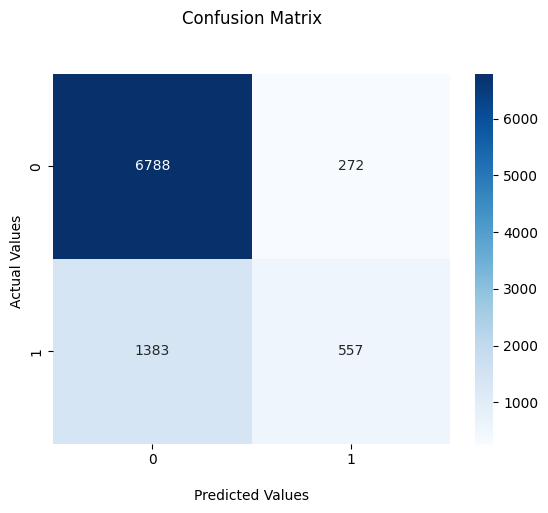

In [75]:
from sklearn.metrics import confusion_matrix
predictions_forest = model_forest.predict(X_test)
cm = confusion_matrix(y_test, predictions_forest)
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_forest))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7060
           1       0.67      0.29      0.40      1940

    accuracy                           0.82      9000
   macro avg       0.75      0.62      0.65      9000
weighted avg       0.80      0.82      0.79      9000



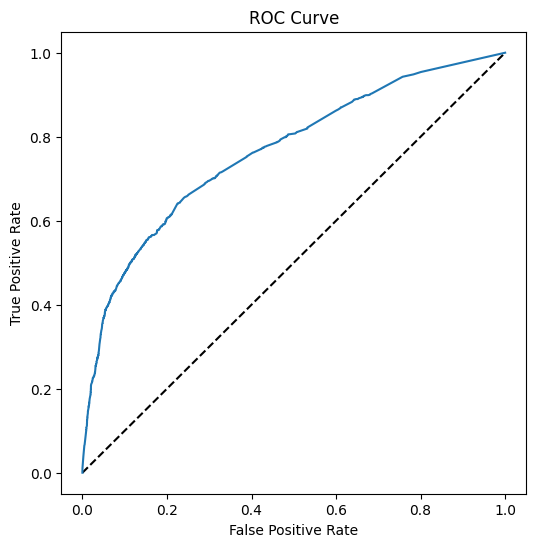

AUC: 0.7644555503635992


In [77]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
predictions_probability_forest = model_forest.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, predictions_probability_forest[:,1])
fig = plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
auc = roc_auc_score(y_test, predictions_probability_forest[:,1])
print('AUC: ' + str(auc))

In [78]:
from sklearn.model_selection import GridSearchCV

random_forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
params_rf = {'max_depth': [3, 5, 10, 20],
             'min_samples_leaf': [3, 5, 10, 15]}
rf_gridsearch = GridSearchCV(random_forest,
                             params_rf,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)
rf_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)
rf_model_v2 = rf_gridsearch.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best hyperparameter: {'max_depth': 5, 'min_samples_leaf': 15}


In [79]:
predictions_forest_v2 = rf_model_v2.predict(X_test)
print(classification_report(y_test, predictions_forest_v2))

              precision    recall  f1-score   support

           0       0.84      0.95      0.90      7060
           1       0.68      0.36      0.47      1940

    accuracy                           0.83      9000
   macro avg       0.76      0.66      0.68      9000
weighted avg       0.81      0.83      0.80      9000



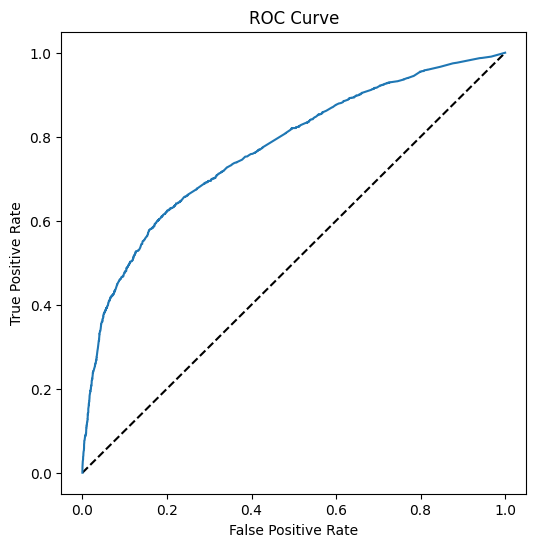

AUC: 0.7696756081890131


In [80]:
predictions_probability_forest_v2 = rf_model_v2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, predictions_probability_forest_v2[:,1])
fig = plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
auc = roc_auc_score(y_test, predictions_probability_forest_v2[:,1])
print('AUC: ' + str(auc))

In [84]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [87]:
X, y = dataframe[dataframe.columns[~dataframe.columns.isin(["Y"])]].astype("float"), dataframe["Y"].astype("int")

In [89]:
model_baseline = Sequential()
model_baseline.add(Dense(60, input_shape=(23,), activation='relu'))
model_baseline.add(Dense(1, activation='sigmoid'))
model_baseline.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_baseline.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 60)                  │           1,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              61 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,501 (5.86 KB)

 Trainable params: 1,501 (5.86 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
estimator = KerasClassifier(model=model_baseline, epochs=20, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 77.86% (0.04%)
